In [1]:
from portfolio_tester.config import Asset, Portfolio, SamplerConfig, SimConfig, Goal
from portfolio_tester.data.fetchers import fetch_prices_monthly, prep_returns_and_macro, fetch_fred_series
from portfolio_tester.sampling.bootstrap import ReturnSampler
from portfolio_tester.engine.simulator import MonteCarloSimulator
from portfolio_tester.analytics.metrics import cagr, twrr_annualized, max_drawdown
import numpy as np

In [2]:
# 1) Portfolio (MVP)
p = Portfolio([
    Asset("VTI","Vanguard Total Stock Market ETF",0.30),
    Asset("TLT","iShares 20+ Year Treasury Bond ETF",0.40),
    Asset("IEF","iShares 7-10 Year Treasury Bond ETF",0.15),
    Asset("GSG","iShares S&P GSCI Commodity-Indexed Trust",0.075),
    Asset("GLD","SPDR Gold Shares",0.075),
])


In [3]:

# 2) Configs
sim_cfg = SimConfig(horizon_months=30*12, n_sims=100, starting_balance=1_000_000)  # start with 100 sims
sam_cfg = SamplerConfig(mode="single_year", block_years=1, seed=42)

goals = [
    # Withdraw $4,000/mo starting in 1 year, for 30 years, inflation-indexed (real)
    Goal("Retirement Withdrawals", amount=-4000, start_month=12, frequency=12, repeats=30*12, real=True),
]


In [4]:
# 3) Data
tickers = p.tickers()
prices_m = fetch_prices_monthly(tickers)
rets_m, infl_m, rf_m = prep_returns_and_macro(prices_m)



In [5]:
# 4) Sample paths
sampler = ReturnSampler(rets_m, infl_m)
R_paths, CPI_paths = sampler.sample(sim_cfg.horizon_months, sim_cfg.n_sims, sam_cfg)

In [6]:
# 5) Run simulation
sim = MonteCarloSimulator(weights=p.weights_vector(), starting_balance=sim_cfg.starting_balance, rebalance_every_months=sim_cfg.rebalance_every_months)
out = sim.run_with_cashflows(R_paths, CPI_paths, goals)

In [7]:
# 6) Simple summary
surv = (out["failure_month"] == -1).mean()
cagr_vals = cagr(out["balances"], sim_cfg.horizon_months)
twrr_vals = twrr_annualized(out["twrr_monthly"])
mdd_vals = max_drawdown(out["balances"])

def pct(x): return f"{100*x:.1f}%"
print("=== Monte Carlo Summary (100 sims) ===")
print(f"Survival rate: {pct(surv)}")
print(f"End balance (nominal) median: ${np.median(out['balances'][:,-1]):,.0f}")
print(f"CAGR median: {np.nanmedian(cagr_vals):.2%}")
print(f"TWRR median: {np.nanmedian(twrr_vals):.2%}")
print(f"Max Drawdown median: {np.median(mdd_vals):.1%}")
print("Percentiles (10/50/90) - End Balance:",
        [f"${v:,.0f}" for v in np.percentile(out['balances'][:,-1], [10,50,90])])

=== Monte Carlo Summary (100 sims) ===
Survival rate: 69.0%
End balance (nominal) median: $669,896
CAGR median: -1.33%
TWRR median: 5.52%
Max Drawdown median: -54.3%
Percentiles (10/50/90) - End Balance: ['$0', '$669,896', '$3,352,258']


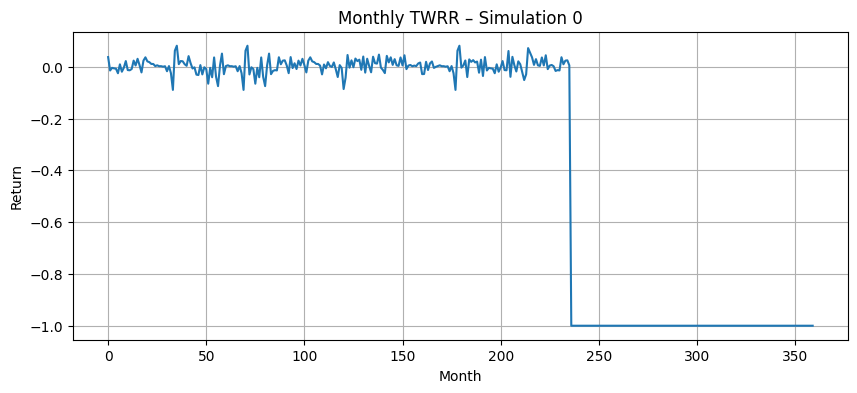

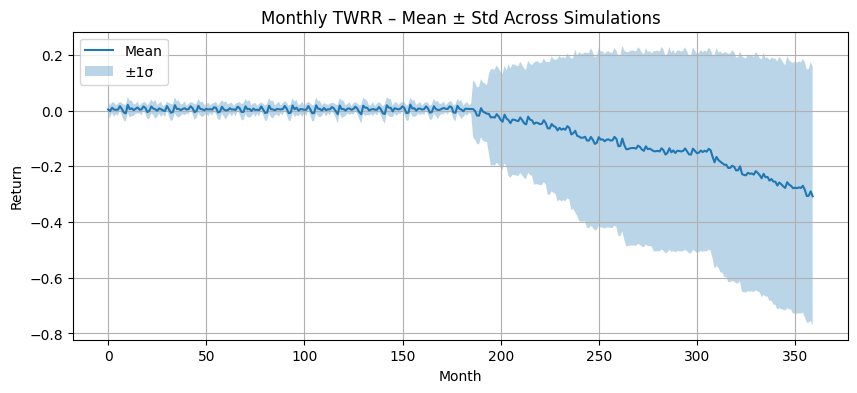

In [19]:


import numpy as np
import matplotlib.pyplot as plt

twrr = out["twrr_monthly"]  # shape: (n_sims, T)

# 1) Plot a single simulation’s path
plt.figure(figsize=(10, 4))
plt.plot(twrr[1])
plt.title("Monthly TWRR – Simulation 0")
plt.xlabel("Month")
plt.ylabel("Return")
plt.grid(True)
plt.show()

# 2) Optionally add the mean ±1 std band over all simulations
mean = twrr.mean(axis=0)
std = twrr.std(axis=0)
months = np.arange(twrr.shape[1])

plt.figure(figsize=(10, 4))
plt.plot(months, mean, label="Mean")
plt.fill_between(months, mean - std, mean + std, alpha=0.3, label="±1σ")
plt.title("Monthly TWRR – Mean ± Std Across Simulations")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()




In [18]:
mdd_vals

array([-0.48340511, -1.        , -0.23599453, -1.        , -0.46006462,
       -0.89865114, -0.78263977, -0.30702183, -0.30986272, -0.49980102,
       -0.22013964, -0.49350717, -1.        , -0.23870346, -0.26343224,
       -0.94439056, -0.41951243, -1.        , -0.36107043, -0.84659156,
       -1.        , -0.54456979, -0.44775307, -0.18411146, -1.        ,
       -0.61424052, -1.        , -1.        , -0.61582464, -0.77741837,
       -0.51519714, -0.27313301, -0.38981554, -1.        , -1.        ,
       -0.24812769, -1.        , -0.99072104, -1.        , -0.15249792,
       -1.        , -1.        , -0.23044156, -0.38190954, -1.        ,
       -1.        , -0.36955339, -0.33302591, -0.37689224, -0.34051465,
       -0.36807662, -0.74651056, -0.24916235, -0.25240043, -0.36547354,
       -1.        , -0.23864333, -1.        , -0.32839598, -0.31113871,
       -1.        , -0.63385996, -0.88919861, -1.        , -1.        ,
       -1.        , -0.67405701, -0.66691441, -0.12747701, -0.34